# EDA

In [3]:
# Get packages
using CSV, DataFrames, wgregseq, CairoMakie, Statistics, BioSequences, StatsBase

# Set colors and plotting style
wgregseq.viz.plotting_style()

┌ Warning: Font 'Lato-Regular' not found. Defaulting to NotoSans...
└ @ wgregseq.viz /Users/tomroeschinger/git/1000_genes_ecoli/src/viz.jl:174


2-element Vector{Any}:
 Dict("light_blue" => "#5fa6db", "light_red" => "#e89290", "primary_blue" => "#3373ba", "green" => "#488d48", "pale_red" => "#eeb3b0", "light_green" => "#99d097", "primary_green" => "#5cb75b", "light_black" => "#8c8c8c", "gold" => "#b1843e", "pale_blue" => "#8ec1e8"…)
 ["#4c4b4c", "#3373ba", "#5cb75b", "#8066ad", "#f0ad4d", "#d8534f"]

## Import mapping data

Import the table mapping barcodes to promoter variants and filter out anything that has less than 3 reads, as well as anything with more than 30 mutations.

In [4]:
df_map = CSV.read(
    "../../../data/barcodes/20220514_mapping/mapped_barcodes.csv", 
    DataFrame, 
);

# Filter out unnannotad sequences
df_map = df_map[df_map.name .!= "*", :]

# Filter out non-unique barcodes
gdf = groupby(df_map[(df_map.map_count .> 2), :], :barcode)
_df = DataFrame()
for df in gdf
    if nrow(df) == 1
        append!(_df, df)
    end
end
df_map = copy(_df);

# Get twist order to get wild type sequences
df_seqs = wgregseq.utils.import_twist_order("../../../data/twist_orders/2022-02-15_twist_order.csv")
df_wt = df_seqs[1:1501:119*1501, :];
insertcols!(df_wt, 4, :promoter_seq => [string(x[27:186]) for x in df_wt.sequence])

df_wt.promoter_seq |> unique |> length
df_map = leftjoin(df_map, rename(df_wt[!, [:promoter, :promoter_seq]], :promoter => :name), on="name")
rename!(df_map, :promoter_seq => :wt_seq);

CSV.write("20220514_mapping_processed.csv", df_map) 

"20220514_mapping_processed.csv"

## What is the pool made of?

In [3]:
df_genelist = CSV.read(
    "../../../data/100_genes_edited.csv",
    comment="#",
    DataFrame,
)
combine(groupby(df_genelist, :group), nrow) |> display
println(nrow(df_genelist))

Row,group,nrow
,String,Int64
1,Gold Standard,16
2,Antibiotic/toxin,18
3,Inc-4 (x) - stress,1
4,Inc-4 (y) - stress,1
5,Inc-4 (z) - stress,1
6,Inc-1 (x),1
7,Inc-1 (y),1
8,Inc-1 (z1),1
9,Inc-1 (z2),1


104


Check that all genes in the list are in the list of promoters.

In [94]:
filter(x -> .~ any(map(y -> x ∈ y, df_wt.genes)), df_genelist.name)

String7[]

Check that at every promoter has one gene that is in the list.

In [95]:
filter(y -> sum(map(x -> x ∈ df_genelist.name, y)) == 0, df_wt.genes)

1-element Vector{Vector{String}}:
 ["kbp"]

How many promoters per gene in gene list.

In [96]:
insertcols!(df_genelist, 3, :n_promoters => map(x -> sum(map(y -> x ∈ y, df_wt.genes)), df_genelist.name))
sort!(df_genelist, :n_promoters, rev=true)

Row,name,group,n_promoters,protein_function
,String7,String,Int64,String?
1,ompR,Inc-4 (y) - stress,4,OmpR phosphorylated DNA-binding transcriptional dual regulator
2,galE,Inc-1 (z2),4,UDP-glucose 4-epimerase
3,tolC,Antibiotic/toxin,4,"Outer membrane channel of efflux system, pumps out toxins, antibiotics"
4,fur,YmfT_modulon,4,missing
5,lacI,Gold Standard,3,DNA-binding transcriptional repressor LacI
6,crp,Inc-1 (x),3,DNA-binding transcriptional dual regulator (activator/repressor)
7,rcsB,YgeV_modulon,3,missing
8,ftsK,Gold Standard,2,cell division DNA translocase FtsK
9,ihfA,Inc-4 (x) - stress,2,DNA-binding transcriptional dual regulator (integration host factor subunit)


In [80]:
names  = df_map.name |> unique
filter(x -> occursin("predicted", x), names) |> length |> println
filter(x -> occursin("regulondb", x), names) |> length |> println
filter(x ->  (.~ occursin("predicted", x) .& .~ occursin("regulondb", x)), names) |> length |> println
println(length(names))

29
5
78
112


In [40]:
vcat(unique(df_seqs.genes)...) |> unique |> sort|> println

["aceA", "aceB", "aceK", "acrA", "acrB", "acrZ", "araA", "araB", "araC", "araD", "beeE", "blr", "btuF", "cpxA", "cpxR", "crp", "cusA", "cusB", "cusC", "cusF", "dgoA", "dgoD", "dgoK", "dgoR", "dgoT", "dicA", "dicC", "dinQ", "ecnB", "elaB", "emrA", "emrB", "envZ", "fldA", "ftsK", "fur", "galE", "galK", "galM", "galS", "galT", "gatA", "gatB", "gatC", "gatD", "gatY", "gatZ", "ghoS", "ghoT", "gyrA", "hdeA", "hdeB", "hokD", "hyuA", "icdC", "ihfA", "insX", "intE", "jayE", "kbp", "lacI", "ldrD", "lipB", "lpp", "marA", "marB", "marR", "mcbA", "mglA", "mglB", "mglC", "mhpR", "mprA", "mtn", "ompF", "ompR", "pheM", "pheS", "pheT", "prlF", "ratA", "rcsB", "rcsD", "rdlD", "recN", "relB", "relE", "rspA", "rspB", "speD", "speE", "ssnA", "stfE", "sulA", "tabA", "tfaE", "tfaP", "tisB", "tmaR", "tnaA", "tnaB", "tnaC", "tolC", "uacT", "uof", "xdhA", "xdhB", "xdhC", "xdhD", "xisE", "xylA", "xylB", "xylF", "xylG", "xylH", "xylR", "yacC", "yacH", "yadC", "yadE", "yadG", "yadH", "yadI", "yadK", "yadL", "yadM"

In [45]:
df_wt[map(x -> occursin("regulondb", x), df_wt.promoter), :]

Row,genes,sequence,promoter,promoter_seq,fwd_primer,rev_primer1,rev_primer2,rev_primer3,upstream_re_site,downstream_re_site,name
,Array…,LongSequ…,String,String,Tuple…,Tuple…,Tuple…,Tuple…,String7,String7,String
1,"[""dicA""]",ACCTGTAATTCCAAGCGTCTACTAGTTTCATCGTCAATACGCAGGTTAATGCTACCCATGTCTTACACCTCTTGTAATTACAAATGTCATTACAAGTATCGCACTACAACATGCTTAGGGCAAGTCACGAAGGAAGTCAGAAAGTAGTCGTAAGAACGGTGATCACTGTCCGCTTTGTGCCAGGAGGGGCCCCTATGGTCATTCCCGTACGCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC,TSS_6311_regulondb,TTCATCGTCAATACGCAGGTTAATGCTACCCATGTCTTACACCTCTTGTAATTACAAATGTCATTACAAGTATCGCACTACAACATGCTTAGGGCAAGTCACGAAGGAAGTCAGAAAGTAGTCGTAAGAACGGTGATCACTGTCCGCTTTGTGCCAGGAG,"(100, (1, 20))","(100, (231, 250))","(113, (193, 211))","(202, (212, 230))",SpeI,ApaI,TSS_6311_regulondb_0
2,"[""yjjJ""]",ACCTGTAATTCCAAGCGTCTACTAGTTGCTGGACTCATTCGGCATCGGCGCTACAGAAGATGCAGAACGCTTTGGTGACGTCGGGGCTGACACCCTGGGTCATATCGCAGAAGCTTGTGCCAAAGGCGAAGCTGATAACGGTCGTAAAGGCCCGCTCAATCTGCCAAATCTGACCCGTCTGGGGCTGGGCCCCTATGGTCATTCCCGTACGCGTAAGGACAGTAGCAAGGGAATACGTGCCTGAGACAAC,TSS_18061_regulondb,TGCTGGACTCATTCGGCATCGGCGCTACAGAAGATGCAGAACGCTTTGGTGACGTCGGGGCTGACACCCTGGGTCATATCGCAGAAGCTTGTGCCAAAGGCGAAGCTGATAACGGTCGTAAAGGCCCGCTCAATCTGCCAAATCTGACCCGTCTGGGGCT,"(100, (1, 20))","(100, (231, 250))","(113, (193, 211))","(201, (212, 230))",SpeI,ApaI,TSS_18061_regulondb_0
3,"[""yahM""]",ACCTGTAATTCCAAGCGTCTACTAGTGATGACGACAAACTCATTCATCTCATGGCTGCCGTACGAGACTGTGAGTGGTCAGACGATAACGCACTCACCATAAATGTGCAGTTTAATGATTTCCCTGGATTTTATGACTGGATGGATTACCCTGATCACCCGGTTAAGTTTGTTTTTCACATACTTGGGGCCCTAATCGGCTACGTTGTGTCTGATAGCCAGCGAAACGATGAATACGTGCCTGAGACAAC,TSS_1414_storz_regulondb,GATGACGACAAACTCATTCATCTCATGGCTGCCGTACGAGACTGTGAGTGGTCAGACGATAACGCACTCACCATAAATGTGCAGTTTAATGATTTCCCTGGATTTTATGACTGGATGGATTACCCTGATCACCCGGTTAAGTTTGTTTTTCACATACTTG,"(100, (1, 20))","(100, (231, 250))","(114, (193, 211))","(204, (212, 230))",SpeI,ApaI,TSS_1414_storz_regulondb_0
4,"[""ymfJ""]",ACCTGTAATTCCAAGCGTCTACTAGTGAACGTGAACATAAAACTGGTTCATTAAGTTTCCTTGCTTGCTGGCTGTGTGAGAACTCCAGCATACCACCGAGCCTGAAGTGGTGAAAAGACAGGCACATAACAGCTAAGTATTTTCAACCAGAGAGAATCCTTAGCGTTGTGGTGAATGCGGCTCAGCGGGCCCTAATCGGCTACGTTGTGTCGGAGAACGGTCAACTATCCGAATACGTGCCTGAGACAAC,TSS_4654_wanner_regulondb,GAACGTGAACATAAAACTGGTTCATTAAGTTTCCTTGCTTGCTGGCTGTGTGAGAACTCCAGCATACCACCGAGCCTGAAGTGGTGAAAAGACAGGCACATAACAGCTAAGTATTTTCAACCAGAGAGAATCCTTAGCGTTGTGGTGAATGCGGCTCAGC,"(100, (1, 20))","(100, (231, 250))","(114, (193, 211))","(205, (212, 230))",SpeI,ApaI,TSS_4654_wanner_regulondb_0
5,"[""ymfJ""]",ACCTGTAATTCCAAGCGTCTACTAGTGGTCTGTTCGGCTGTGTCTTCAAATAGACGAACGTGAACATAAAACTGGTTCATTAAGTTTCCTTGCTTGCTGGCTGTGTGAGAACTCCAGCATACCACCGAGCCTGAAGTGGTGAAAAGACAGGCACATAACAGCTAAGTATTTTCAACCAGAGAGAATGGGCCCTAATCGGCTACGTTGTGTCGGAGAACGGTCAACTATCCGAATACGTGCCTGAGACAAC,TSS_4655_regulondb,GGTCTGTTCGGCTGTGTCTTCAAATAGACGAACGTGAACATAAAACTGGTTCATTAAGTTTCCTTGCTTGCTGGCTGTGTGAGAACTCCAGCATACCACCGAGCCTGAAGTGGTGAAAAGACAGGCACATAACAGCTAAGTATTTTCAACCAGAGAGAAT,"(100, (1, 20))","(100, (231, 250))","(114, (193, 211))","(205, (212, 230))",SpeI,ApaI,TSS_4655_regulondb_0


In [46]:
df_wt[map(x -> "ratA" ∈ x,  df_wt.genes), :]

Row,genes,sequence,promoter,promoter_seq,fwd_primer,rev_primer1,rev_primer2,rev_primer3,upstream_re_site,downstream_re_site,name
,Array…,LongSequ…,String,String,Tuple…,Tuple…,Tuple…,Tuple…,String7,String7,String
1,"[""ratA"", ""yfjF""]",ACCTGTAATTCCAAGCGTCTACTAGTTGTTTCTTACCTTTGGCGACGCCGATTTTCACTTTGCACCAGGCATTTTTCCAGTACAGGGAGAGCGCCACTACGGTATAGCCTTCTCGATTGACGCGACCGTACAATGAGTCCAGTTCGCGCTGGTTGAGAAGTAACTTGCGGGTACGGGTAGGATCGCGGGCCCACCACGGTGGAGTATACATCGTAAGGACAGTAGCAAGGGAATACGTGCCTGAGACAAC,ratA_yfjF_predicted,TGTTTCTTACCTTTGGCGACGCCGATTTTCACTTTGCACCAGGCATTTTTCCAGTACAGGGAGAGCGCCACTACGGTATAGCCTTCTCGATTGACGCGACCGTACAATGAGTCCAGTTCGCGCTGGTTGAGAAGTAACTTGCGGGTACGGGTAGGATCGC,"(100, (1, 20))","(100, (231, 250))","(117, (193, 211))","(201, (212, 230))",SpeI,ApaI,ratA_yfjF_predicted_0


## Import Barcode codes and map to promoters

In [3]:
function get_dataset(i)
    if  isfile("../../../data/extracted_barcodes/20231207_barcode/$(i)_DNA_collapsed.txt")
        df_DNA = CSV.read(
            "../../../data/extracted_barcodes/20231207_barcode/$(i)_DNA_collapsed.txt", 
            DataFrame, 
            ignorerepeated=true, 
            delim=" ", 
            header=["ct_0", "barcode"]
        )
        # import RNA
        df_RNA = CSV.read(
            "../../../data/extracted_barcodes/20231207_barcode/$(i)_RNA_collapsed.txt", 
            DataFrame, 
            ignorerepeated=true, 
            delim=" ", 
            header=["ct_1", "barcode"]
        )
    else
        df_DNA = CSV.read(
            "../../../data/extracted_barcodes/20230907_barcode/temp/$(i)_DNA_collapsed.txt", 
            DataFrame, 
            ignorerepeated=true, 
            delim=" ", 
            header=["ct_0", "barcode"]
        )
        # import RNA
        df_RNA = CSV.read(
            "../../../data/extracted_barcodes/20230907_barcode/temp/$(i)_RNA_collapsed.txt", 
            DataFrame, 
            ignorerepeated=true, 
            delim=" ", 
            header=["ct_1", "barcode"])
    end
    
    # merge DNA and RNA reads
    df = outerjoin(df_DNA, df_RNA, on=:barcode)
    
    # replace missing reads with 0
    replace!(df.ct_0, missing => 0)
    replace!(df.ct_1, missing => 0)
    
    # identify promoter sequences
    df = innerjoin(df, df_map, on=:barcode)
    
    # compute total counts
    insertcols!(df, 1, :ct => df.ct_0 .+ df.ct_1)
    insertcols!(df, 1, :relative_counts => (df.ct_1 .+ 1) ./ (df.ct_0 .+ 1))
    
    # Turn sequences into integer
    insertcols!(df, 3, :int_promoter => wgregseq.footprints.make_int.(df[:, :promoter]))
    insertcols!(df, 3, :int_wt => wgregseq.footprints.make_int.(df[:, :wt_seq]));
    return df
end

get_dataset (generic function with 1 method)

### Glucose - Total reads per promoter

In [14]:
# get list of growth condition labels
growth_conditions = CSV.read("growth_conditions.csv", DataFrame)
# Get all growth condition indexes
gcs = unique([x[1] for x in split.(vcat(readdir("../../../data/extracted_barcodes/20230907_barcode/temp"), readdir("../../../data/extracted_barcodes/20231207_barcode/")), "_")])
com_df = DataFrame()

# go through each growth condition and combine data
for gc_ind in gcs
    gc = growth_conditions[parse(Int64, split(gc_ind, '-')[1]), :Condition]
    df = get_dataset(gc_ind)
    rep = split(gc_ind, '-')[2]

    # create canvas
    fig = Figure(size=(1700, 800))
    ga = fig[1, 1] = GridLayout()
    gb = fig[2, 1] = GridLayout()
    # get total RNA and DNA counts per promoter
    gdf = combine(groupby(df, :name), [:ct_0, :ct_1] => ((x, y) -> (total_DNA=sum(x), total_RNA=sum(y))) => AsTable)
    stacked = stack(sort(gdf, :total_DNA, rev=true), 2:3)

    # Plot DNA counts against RNA counts for each promoter
    ax = Axis(ga[1, 1], xlabel="DNA counts", ylabel="RNA counts")
    scatter!(ax, gdf.total_DNA, gdf.total_RNA)

    # Plot Histograms for 
    bx1 = Axis(gb[1, 1], xlabel="DNA counts", ylabel="RNA counts")
    hist!(bx1, gdf.total_DNA)
    bx2 = Axis(gb[1, 2], xlabel="RNA counts", ylabel="histogram")
    hist!(bx2, gdf.total_RNA)
    bx3 = Axis(gb[1, 3], xlabel="relative counts", ylabel="histogram")
    hist!(bx3, gdf.total_RNA ./ gdf.total_DNA)
    bx4 = Axis(gb[1, 4], xlabel="relative counts", ylabel="ECDF")
    lines!(bx4, sort(gdf.total_RNA ./ gdf.total_DNA), 1/length(gdf.total_DNA):1/length(gdf.total_DNA):1)
    
    bx5 = Axis(gb[1, 5], title="Most increased expression\n(compared to Glucose)", backgroundcolor="white")
    bx6 = Axis(gb[1, 6], title="Most reduced expression\n(compared to Glucose)", backgroundcolor="white")
    if gc_ind != "1-1"
        df_ref = get_dataset("1-1")
        gdf_ref = combine(groupby(df_ref, :name), [:ct_0, :ct_1] => ((x, y) -> (total_DNA=sum(x), total_RNA=sum(y))) => AsTable)
        _df = innerjoin(gdf, gdf_ref, on=:name, makeunique=true)
        insertcols!(_df, 3, :fc_relative_counts => _df.total_RNA  ./ _df.total_DNA ./ (_df.total_RNA_1 ./ _df.total_DNA_1) .* (sum(_df.total_RNA_1) / sum(_df.total_RNA) * sum(_df.total_DNA) /sum(_df.total_DNA_1)))
        sort!(_df, :fc_relative_counts, rev=true)
        for i in 1:10
            text!(bx5, string(_df.name[i]) * ": " * string(round(_df.fc_relative_counts[i], digits=3)), position=(1, 10-i))
            text!(bx6, string(_df.name[end-(i+1)]) * ": " * string(round(_df.fc_relative_counts[end-(i+1)], digits=3)), position=(1, 10-i))
        end
    end
    hidedecorations!(bx5)
    hidedecorations!(bx6)
    hidespines!(bx5)
    hidespines!(bx6)
    ylims!(bx5, 0, 10)
    ylims!(bx6, 0, 10)
    xlims!(bx5, 1, 10)
    xlims!(bx6, 1, 10)


    


    ax2 = Axis(ga[1, 2:5], ylabel="counts", xticks=(1:length(unique(stacked.name)), unique(stacked.name)), xticklabelrotation=π/4, xticklabelsize=7)
    name_dict = Dict(unique(stacked.name) .=> collect(1:length(unique(stacked.name))))
    acid_dict = Dict("total_DNA" => 1, "total_RNA" => 2)
    acid_dict_color = Dict("total_DNA" => 2, "total_RNA" => 1)

    insertcols!(stacked, 1, :name_int => map(x -> name_dict[x], stacked.name))
    insertcols!(stacked, 2, :acid_int => map(x -> acid_dict[x], stacked.variable))

    barplot!(
        ax2,
        stacked.name_int, 
        stacked.value, 
        dodge=convert(Vector{Int64}, map(x -> acid_dict[x], stacked.variable)),
        color=convert(Vector{Int64}, map(x -> acid_dict_color[x], stacked.variable)),
        colormap=colors[[2, 1]]
    )

    labels = ["DNA counts", "RNA counts"]
    elements = [PolyElement(polycolor = colors[i], width=1) for i in 1:length(labels)]

    Legend(ga[1,5], elements, labels, patchsize=(20, 20), rowgap=10, valign=:top)

    Label(ga[1, 1:5, Top()], "$gc-$rep", valign = :bottom,
        font = :bold,
        fontsize = 20,
        padding = (0, 0, 5, 0))

    save("gc_checks/$(gc_ind)_count_dist.pdf", fig)
end


In [10]:
round(3.333, digits=2)

3.33

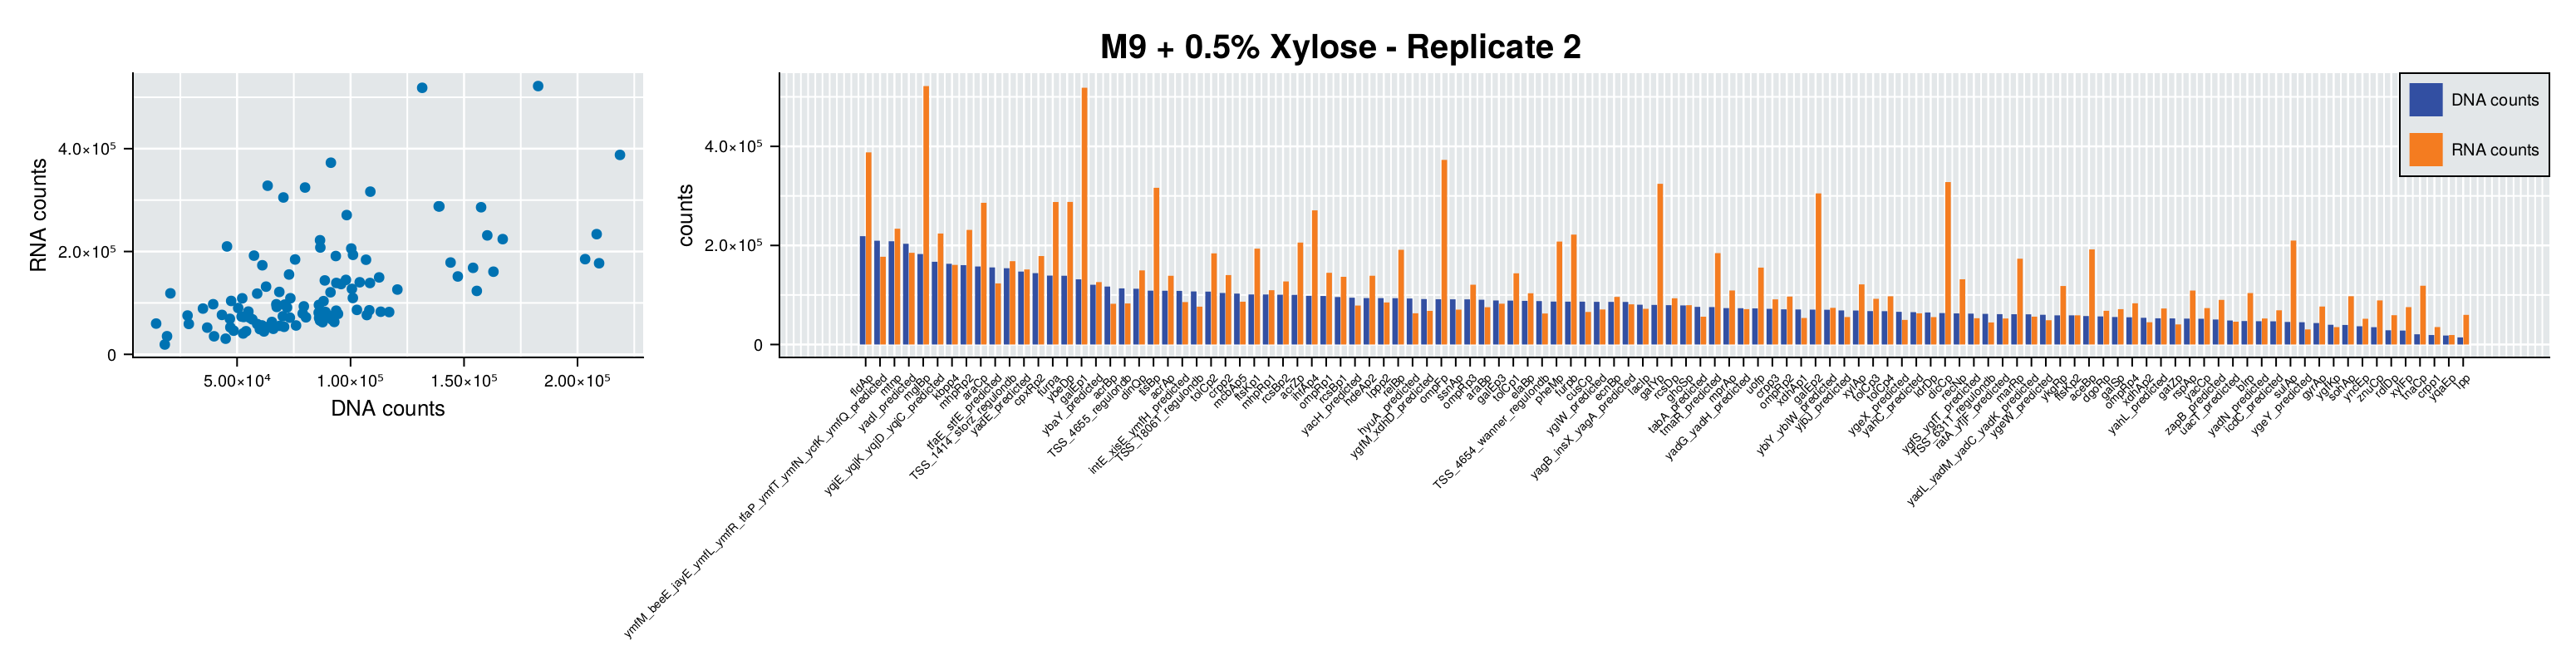

In [7]:
df = get_dataset("2-2");

gdf = combine(groupby(df, :name), [:ct_0, :ct_1] => ((x, y) -> (total_DNA=sum(x), total_RNA=sum(y))) => AsTable)
stacked = stack(sort(gdf, :total_DNA, rev=true), 2:3)
fig = Figure(size=(1550, 400))

ga = fig[1, 1] = GridLayout()
ax = Axis(ga[1, 1], xlabel="DNA counts", ylabel="RNA counts")
scatter!(ax, gdf.total_DNA, gdf.total_RNA)

ax2 = Axis(ga[1, 2:5], ylabel="counts", xticks=(1:length(unique(stacked.name)), unique(stacked.name)), xticklabelrotation=π/4, xticklabelsize=7)
name_dict = Dict(unique(stacked.name) .=> collect(1:length(unique(stacked.name))))
acid_dict = Dict("total_DNA" => 1, "total_RNA" => 2)
acid_dict_color = Dict("total_DNA" => 2, "total_RNA" => 1)

insertcols!(stacked, 1, :name_int => map(x -> name_dict[x], stacked.name))
insertcols!(stacked, 2, :acid_int => map(x -> acid_dict[x], stacked.variable))

barplot!(
    ax2,
    stacked.name_int, 
    stacked.value, 
    dodge=convert(Vector{Int64}, map(x -> acid_dict[x], stacked.variable)),
    color=convert(Vector{Int64}, map(x -> acid_dict_color[x], stacked.variable)),
    colormap=colors[[2, 1]]
)

labels = ["DNA counts", "RNA counts"]
elements = [PolyElement(polycolor = colors[i], width=1) for i in 1:length(labels)]
title = "Groups"

Legend(ga[1,5], elements, labels, patchsize=(20, 20), rowgap=10, valign=:top)

Label(ga[1, 1:5, Top()], "M9 + 0.5% Xylose - Replicate 2", valign = :bottom,
    font = :bold,
    fontsize = 20,
    padding = (0, 0, 5, 0))

save("2-2_count_dist.pdf", fig)

fig

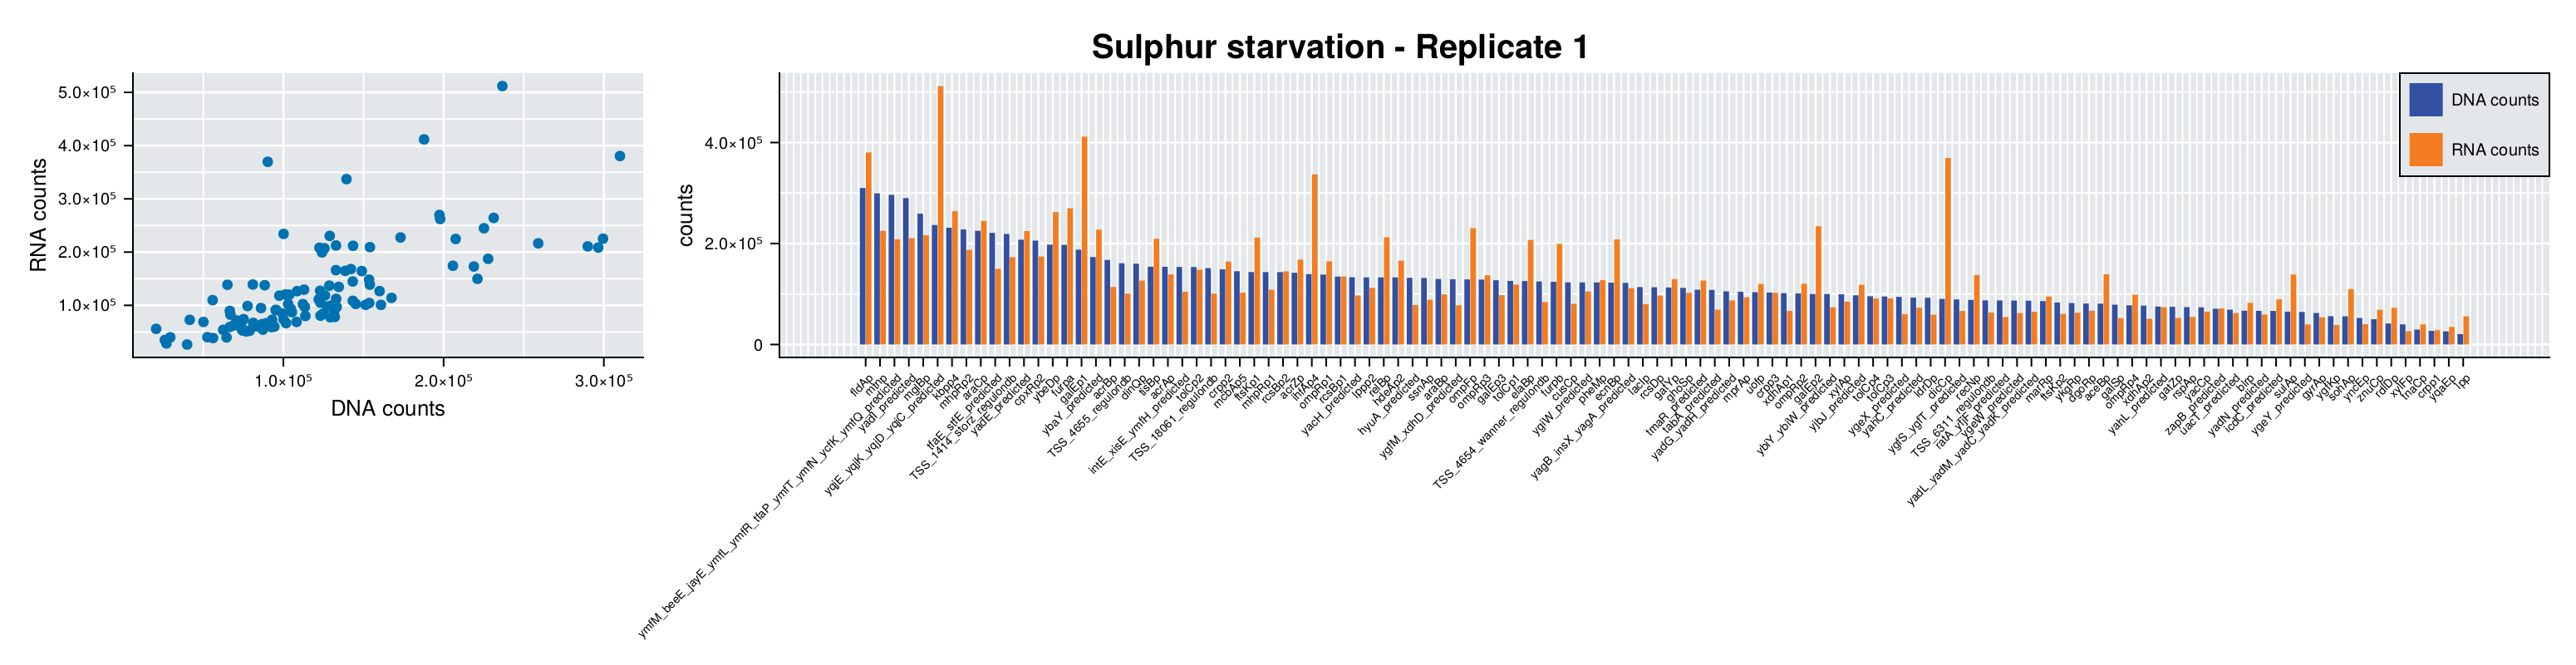

In [8]:
df = get_dataset("16-1");

gdf = combine(groupby(df, :name), [:ct_0, :ct_1] => ((x, y) -> (total_DNA=sum(x), total_RNA=sum(y))) => AsTable)
stacked = stack(sort(gdf, :total_DNA, rev=true), 2:3)
fig = Figure(size=(1550, 400))
ga = fig[1, 1] = GridLayout()
ax = Axis(ga[1, 1], xlabel="DNA counts", ylabel="RNA counts")
scatter!(ax, gdf.total_DNA, gdf.total_RNA)

ax2 = Axis(ga[1, 2:5], ylabel="counts", xticks=(1:length(unique(stacked.name)), unique(stacked.name)), xticklabelrotation=π/4, xticklabelsize=7)
name_dict = Dict(unique(stacked.name) .=> collect(1:length(unique(stacked.name))))
acid_dict = Dict("total_DNA" => 1, "total_RNA" => 2)
acid_dict_color = Dict("total_DNA" => 2, "total_RNA" => 1)

insertcols!(stacked, 1, :name_int => map(x -> name_dict[x], stacked.name))
insertcols!(stacked, 2, :acid_int => map(x -> acid_dict[x], stacked.variable))

barplot!(
    ax2,
    stacked.name_int, 
    stacked.value, 
    dodge=convert(Vector{Int64}, map(x -> acid_dict[x], stacked.variable)),
    color=convert(Vector{Int64}, map(x -> acid_dict_color[x], stacked.variable)),
    colormap=colors[[2, 1]]
)

labels = ["DNA counts", "RNA counts"]
elements = [PolyElement(polycolor = colors[i], width=1) for i in 1:length(labels)]
title = "Groups"

Legend(ga[1,5], elements, labels, patchsize=(20, 20), rowgap=10, valign=:top)

Label(ga[1, 1:5, Top()], "Sulphur starvation - Replicate 1", valign = :bottom,
    font = :bold,
    fontsize = 20,
    padding = (0, 0, 5, 0))

save("16-1_count_dist.pdf", fig)

fig

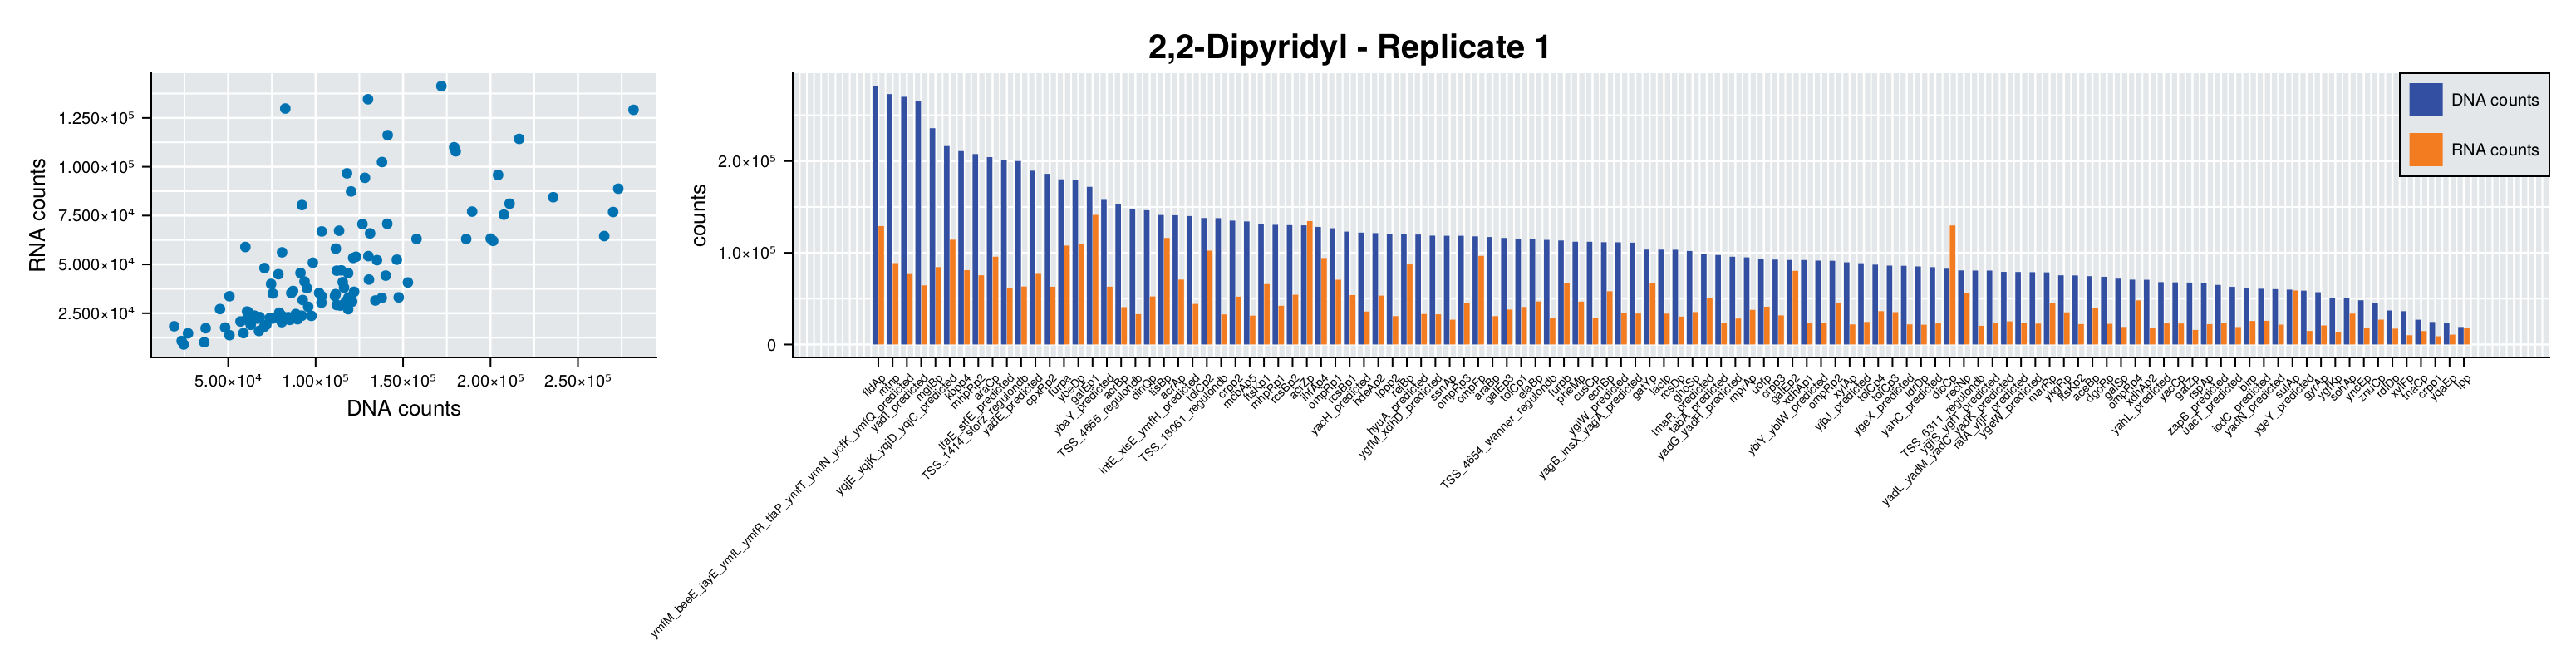

In [9]:
df = get_dataset("24-1");

gdf = combine(groupby(df, :name), [:ct_0, :ct_1] => ((x, y) -> (total_DNA=sum(x), total_RNA=sum(y))) => AsTable)
stacked = stack(sort(gdf, :total_DNA, rev=true), 2:3)
fig = Figure(size=(1550, 400))
ga = fig[1, 1] = GridLayout()
ax = Axis(ga[1, 1], xlabel="DNA counts", ylabel="RNA counts")
scatter!(ax, gdf.total_DNA, gdf.total_RNA)

ax2 = Axis(ga[1, 2:5], ylabel="counts", xticks=(1:length(unique(stacked.name)), unique(stacked.name)), xticklabelrotation=π/4, xticklabelsize=7)
name_dict = Dict(unique(stacked.name) .=> collect(1:length(unique(stacked.name))))
acid_dict = Dict("total_DNA" => 1, "total_RNA" => 2)
acid_dict_color = Dict("total_DNA" => 2, "total_RNA" => 1)

insertcols!(stacked, 1, :name_int => map(x -> name_dict[x], stacked.name))
insertcols!(stacked, 2, :acid_int => map(x -> acid_dict[x], stacked.variable))

barplot!(
    ax2,
    stacked.name_int, 
    stacked.value, 
    dodge=convert(Vector{Int64}, map(x -> acid_dict[x], stacked.variable)),
    color=convert(Vector{Int64}, map(x -> acid_dict_color[x], stacked.variable)),
    colormap=colors[[2, 1]]
)

labels = ["DNA counts", "RNA counts"]
elements = [PolyElement(polycolor = colors[i], width=1) for i in 1:length(labels)]
title = "Groups"

Legend(ga[1,5], elements, labels, patchsize=(20, 20), rowgap=10, valign=:top)

Label(ga[1, 1:5, Top()], "2,2-Dipyridyl - Replicate 1", valign = :bottom,
    font = :bold,
    fontsize = 20,
    padding = (0, 0, 5, 0))

save("24-1_count_dist.pdf", fig)

fig

### Relative expression across growth conditions

In [10]:
# get list of growth condition labels
growth_conditions = CSV.read("growth_conditions.csv", DataFrame)
# Get all growth condition indexes
gcs = unique([x[1] for x in split.(vcat(readdir("../../../data/extracted_barcodes/20230907_barcode/temp"), readdir("../../../data/extracted_barcodes/20231207_barcode/")), "_")])
com_df = DataFrame()

# go through each growth condition and combine data
for gc_ind in gcs
    gc = growth_conditions[parse(Int64, split(gc_ind, '-')[1]), :Condition]
    df = get_dataset(gc_ind)
    gdf = combine(
        groupby(
            df, :name
        ), 
        [:relative_counts, :ct_0, :ct_1] => ((x, y, z) -> (rel_ct=mean(x), ct_0=sum(y), ct_1=sum(z)))=>AsTable
    )
    insertcols!(gdf, 3, "growth_condition" => gc)
    insertcols!(gdf, 3, "growth_condition_ind" => gc_ind)
    append!(com_df, gdf)
    println(gc_ind, " ", gc)
end


1-1 Glucose


10-1 Ampicillin


12-1 H2O2 (0.1mM, 30min)


13-1 LB


2-1 Xylose


3-1 Arabinose


5-1 Sodium Salicytate


6-1 Ethanol


7-1 Stationary Phase (1d)


1-2 Glucose


13-2 LB


14-1 Nirtogen starvation


15-1 Magnesium starvation


16-1 Sulphur starvation


17-1 Sodium Salicytate (induction)


18-1 Ampicillin (induction)


19-1 Ethanol (induction)


19-2 Ethanol (induction)


2-2 Xylose


20-1 Glutamic acid (pH 2.5)


22-1 2pH (HCl)


23-1 Medium Cold shock 19C 


24-1 2,2-Dipyridyl 


25-1 Phenazine Methosulfate 


26-1 Pyruvate


28-1 H2O2 (2.5mM, 10min)


29-1 Gentamycin


3-2 Arabinose


30-1 Copper Sulfate


32-1 Spermidine


33-1 Serine Hydroxamate


35-1 Low Osmolarity


36-1 LB + higher salt concentration - high osmolarity


37-1 Low Phosphate


4-1 Galactose


9-1 Cold Shock (1h at 10C)


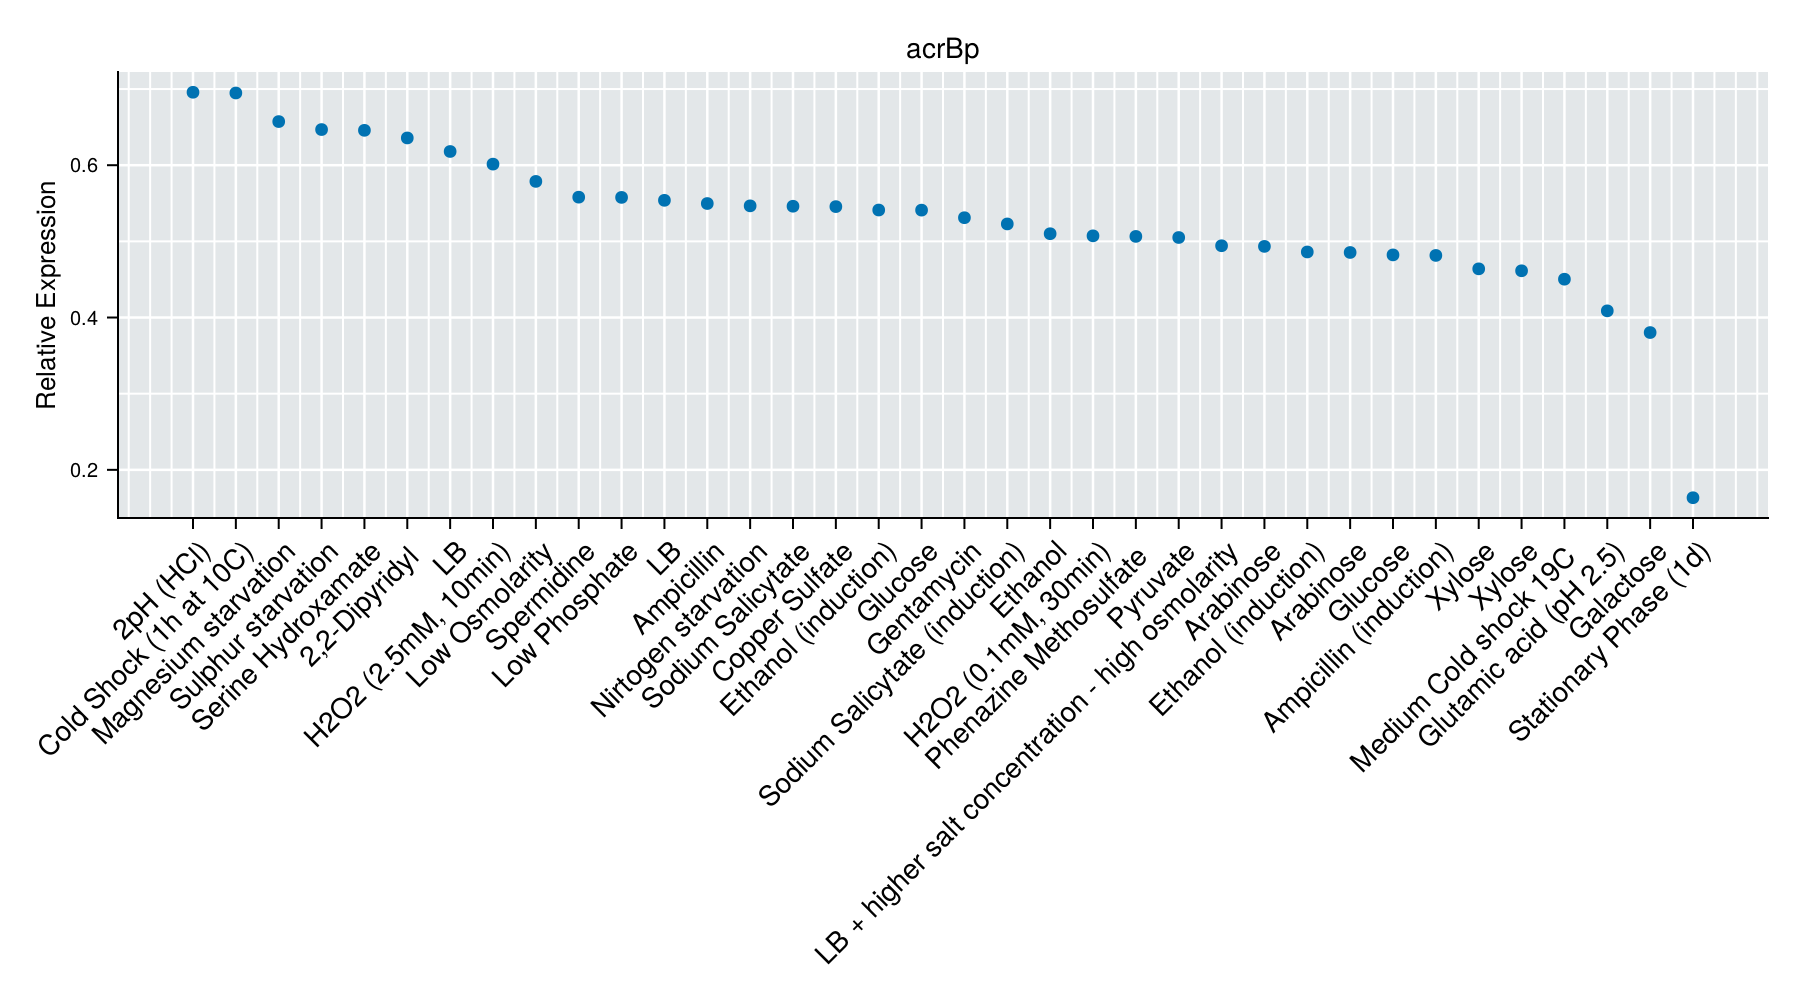

In [11]:
fig = Figure(size=(900, 500))

prom = "acrBp"

# normalize
_df = combine(
    groupby(
        com_df, 
        :growth_condition_ind
        ), 
    [:name, :growth_condition, :ct_0, :ct_1] => ((a, b, x, y) -> (name=a, growth_condition=b, rel=y ./sum(y) ./ (x ./ sum(x))))=>AsTable)
_df = _df[_df.name .== prom, :]
sort!(_df, :rel, rev=true)
ax = Axis(
    fig[1, 1], 
    ylabel="Relative Expression", 
    title=prom, xticks=(1:length(_df.growth_condition), _df.growth_condition),
    xticklabelrotation=π/4,
    xticklabelsize=14,
    titlesize=14
    )
scatter!(ax, _df.rel)
fig

In [1]:
df1 = get_dataset("13-1")
df1 = df1[df1.name .== prom, :]
x = wgregseq.footprints.mutual_information_mutation(df1)

fig = Figure(size=(700, 200))
ax = Axis(fig[1 ,1], title = prom)
barplot!(ax, -115:44, x)
fig

UndefVarError: UndefVarError: `get_dataset` not defined

In [315]:
_df

Row,growth_condition_ind,name,growth_condition,rel
,SubStrin…,String,String,Float64
1,13-2,tmaR_predicted,LB,1.82561
2,18-1,tmaR_predicted,Ampicillin (induction),1.74601
3,3-1,tmaR_predicted,Arabinose,1.72541
4,32-1,tmaR_predicted,Spermidine,1.71071
5,12-1,tmaR_predicted,"H2O2 (0.1mM, 30min)",1.70231
6,6-1,tmaR_predicted,Ethanol,1.69691
7,19-1,tmaR_predicted,Ethanol (induction),1.68909
8,23-1,tmaR_predicted,Medium Cold shock 19C,1.68771
9,30-1,tmaR_predicted,Copper Sulfate,1.66985


### Correlation between growth conditions

In [299]:
gcs = unique([x[1] for x in split.(vcat(readdir("../../../data/extracted_barcodes/20230907_barcode/temp"), readdir("../../../data/extracted_barcodes/20231207_barcode/")), "_")])
growth_conditions = CSV.read("growth_conditions.csv", DataFrame)

sort!(gcs)
corr_mat = zeros(36, 36)
for (i, gc) in enumerate(gcs[1:end-1])
    other_gcs = gcs[i+1:end]
    for (j, _gc) in enumerate(other_gcs)
        df1 = com_df[com_df.growth_condition_ind .== gc, :]
        df2 = com_df[com_df.growth_condition_ind .== _gc, :]
        corr_mat[i, j+i] = cor(df1.rel_ct, df2.rel_ct)
        corr_mat[j+i, i] = cor(df1.rel_ct, df2.rel_ct)
    end
end


In [300]:
corr_mat

36×36 Matrix{Float64}:
 0.0       0.952514  0.998494  0.966526  …  0.981302  0.642907  0.822975
 0.952514  0.0       0.957467  0.983289     0.928859  0.468738  0.883872
 0.998494  0.957467  0.0       0.969283     0.979709  0.634746  0.834555
 0.966526  0.983289  0.969283  0.0          0.956058  0.509495  0.871607
 0.894076  0.82521   0.892828  0.833534     0.886283  0.718422  0.688005
 0.837633  0.928974  0.846675  0.906098  …  0.815957  0.31785   0.860788
 0.913071  0.963838  0.920176  0.944603     0.875709  0.46656   0.91188
 0.77142   0.792665  0.767664  0.804205     0.727333  0.407415  0.712557
 0.811362  0.825332  0.812073  0.807702     0.757663  0.553852  0.733227
 0.849309  0.933148  0.859131  0.908601     0.813121  0.379156  0.868058
 ⋮                                       ⋱                      ⋮
 0.906716  0.958125  0.912723  0.9444       0.883249  0.399996  0.84435
 0.952748  0.983776  0.957019  0.980686     0.932082  0.507768  0.871771
 0.577496  0.607692  0.579261  0.6037

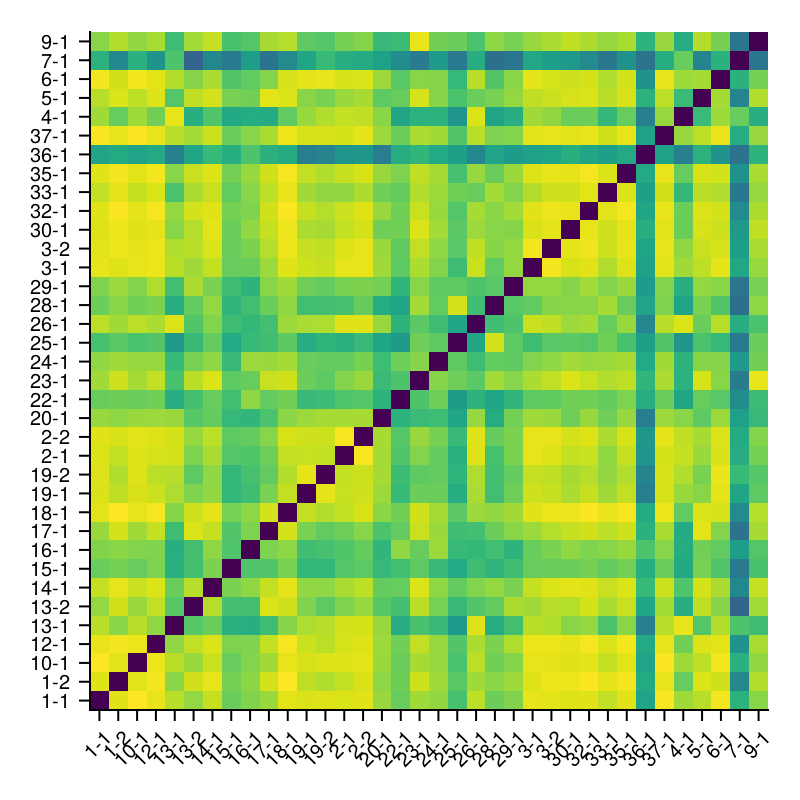

In [301]:
fig = Figure(size=(400, 400))
ax = Axis(fig[1, 1], xticks=(1:36, gcs), yticks=(1:36, gcs), xticklabelrotation=π/4)
heatmap!(ax, corr_mat)
fig

### Dynamic range of expression

In [323]:
df = get_dataset("4-1")
df = df[df.ct_0 .> 1, :]
_df = combine(groupby(df, :name), :relative_counts => (x -> (maximum(x)-minimum(x))/minimum(x)))

sort(_df, :relative_counts_function, rev=true)

Row,name,relative_counts_function
,String,Float64
1,marRp,747839.0
2,sulAp,165978.0
3,ompRp3,111564.0
4,crpp2,1.07463e5
5,ghoSp,98669.0
6,cusCp,95871.0
7,yadE_predicted,94505.7
8,galEp2,92315.7
9,blrp,91857.7


In [25]:
df = innerjoin(get_dataset("19-1"), get_dataset("19-2"), on=:barcode, makeunique=true)

Row,relative_counts,ct,int_wt,int_promoter,ct_0,barcode,ct_1,promoter,map_count,name,wt_seq,relative_counts_1,ct_2,int_wt_1,int_promoter_1,ct_0_1,ct_1_1,promoter_1,map_count_1,name_1,wt_seq_1
,Float64,Int64,Array…,Array…,Int64?,String31,Int64?,String,Int64,String,String?,Float64,Int64,Array…,Array…,Int64?,Int64?,String,Int64,String,String?
1,0.5,1,"[3, 1, 4, 3, 1, 2, 3, 1, 2, 1 … 2, 1, 2, 1, 4, 1, 2, 4, 4, 3]","[1, 1, 1, 3, 1, 2, 3, 1, 2, 1 … 2, 1, 2, 1, 4, 1, 2, 4, 4, 3]",1,AAGCATTTCAACGGAGGACA,0,AAAGACGACAAGCTCATTCATATCAGGGCTGCCGTACGAGACGGTGAGTAGTCAGATGATAACGCCCTGACGATAAATTTGCAGTTTCATGATTTCCCTGTATTTTATGACTGGATGGATTACCCTGATCAGCCTGTTAAGTTTGTTTTTCACATACTTG,13,TSS_1414_storz_regulondb,GATGACGACAAACTCATTCATCTCATGGCTGCCGTACGAGACTGTGAGTGGTCAGACGATAACGCACTCACCATAAATGTGCAGTTTAATGATTTCCCTGGATTTTATGACTGGATGGATTACCCTGATCACCCGGTTAAGTTTGTTTTTCACATACTTG,0.333333,2,"[3, 1, 4, 3, 1, 2, 3, 1, 2, 1 … 2, 1, 2, 1, 4, 1, 2, 4, 4, 3]","[1, 1, 1, 3, 1, 2, 3, 1, 2, 1 … 2, 1, 2, 1, 4, 1, 2, 4, 4, 3]",2,0,AAAGACGACAAGCTCATTCATATCAGGGCTGCCGTACGAGACGGTGAGTAGTCAGATGATAACGCCCTGACGATAAATTTGCAGTTTCATGATTTCCCTGTATTTTATGACTGGATGGATTACCCTGATCAGCCTGTTAAGTTTGTTTTTCACATACTTG,13,TSS_1414_storz_regulondb,GATGACGACAAACTCATTCATCTCATGGCTGCCGTACGAGACTGTGAGTGGTCAGACGATAACGCACTCACCATAAATGTGCAGTTTAATGATTTCCCTGGATTTTATGACTGGATGGATTACCCTGATCACCCGGTTAAGTTTGTTTTTCACATACTTG
2,156.333,942,"[3, 1, 4, 3, 1, 2, 3, 1, 2, 1 … 2, 1, 2, 1, 4, 1, 2, 4, 4, 3]","[1, 1, 1, 3, 1, 2, 3, 1, 2, 1 … 2, 1, 2, 1, 4, 1, 2, 4, 4, 3]",5,AGTCGTCCATTCCTTGACGG,937,AAAGACGACAAGCTCATTCATATCAGGGCTGCCGTACGAGACGGTGAGTAGTCAGATGATAACGCCCTGACGATAAATTTGCAGTTTCATGATTTCCCTGTATTTTATGACTGGATGGATTACCCTGATCAGCCTGTTAAGTTTGTTTTTCACATACTTG,22,TSS_1414_storz_regulondb,GATGACGACAAACTCATTCATCTCATGGCTGCCGTACGAGACTGTGAGTGGTCAGACGATAACGCACTCACCATAAATGTGCAGTTTAATGATTTCCCTGGATTTTATGACTGGATGGATTACCCTGATCACCCGGTTAAGTTTGTTTTTCACATACTTG,8.375,148,"[3, 1, 4, 3, 1, 2, 3, 1, 2, 1 … 2, 1, 2, 1, 4, 1, 2, 4, 4, 3]","[1, 1, 1, 3, 1, 2, 3, 1, 2, 1 … 2, 1, 2, 1, 4, 1, 2, 4, 4, 3]",15,133,AAAGACGACAAGCTCATTCATATCAGGGCTGCCGTACGAGACGGTGAGTAGTCAGATGATAACGCCCTGACGATAAATTTGCAGTTTCATGATTTCCCTGTATTTTATGACTGGATGGATTACCCTGATCAGCCTGTTAAGTTTGTTTTTCACATACTTG,22,TSS_1414_storz_regulondb,GATGACGACAAACTCATTCATCTCATGGCTGCCGTACGAGACTGTGAGTGGTCAGACGATAACGCACTCACCATAAATGTGCAGTTTAATGATTTCCCTGGATTTTATGACTGGATGGATTACCCTGATCACCCGGTTAAGTTTGTTTTTCACATACTTG
3,0.333333,2,"[3, 1, 4, 3, 1, 2, 3, 1, 2, 1 … 2, 1, 2, 1, 4, 1, 2, 4, 4, 3]","[1, 1, 1, 3, 1, 2, 3, 1, 2, 1 … 2, 1, 2, 1, 4, 1, 2, 4, 4, 3]",2,GGAACGGATTAACGCGACCG,0,AAAGACGACAAGCTCATTCATATCAGGGCTGCCGTACGAGACGGTGAGTAGTCAGATGATAACGCCCTGACGATAAATTTGCAGTTTCATGATTTCCCTGTATTTTATGACTGGATGGATTACCCTGATCAGCCTGTTAAGTTTGTTTTTCACATACTTG,182,TSS_1414_storz_regulondb,GATGACGACAAACTCATTCATCTCATGGCTGCCGTACGAGACTGTGAGTGGTCAGACGATAACGCACTCACCATAAATGTGCAGTTTAATGATTTCCCTGGATTTTATGACTGGATGGATTACCCTGATCACCCGGTTAAGTTTGTTTTTCACATACTTG,0.25,3,"[3, 1, 4, 3, 1, 2, 3, 1, 2, 1 … 2, 1, 2, 1, 4, 1, 2, 4, 4, 3]","[1, 1, 1, 3, 1, 2, 3, 1, 2, 1 … 2, 1, 2, 1, 4, 1, 2, 4, 4, 3]",3,0,AAAGACGACAAGCTCATTCATATCAGGGCTGCCGTACGAGACGGTGAGTAGTCAGATGATAACGCCCTGACGATAAATTTGCAGTTTCATGATTTCCCTGTATTTTATGACTGGATGGATTACCCTGATCAGCCTGTTAAGTTTGTTTTTCACATACTTG,182,TSS_1414_storz_regulondb,GATGACGACAAACTCATTCATCTCATGGCTGCCGTACGAGACTGTGAGTGGTCAGACGATAACGCACTCACCATAAATGTGCAGTTTAATGATTTCCCTGGATTTTATGACTGGATGGATTACCCTGATCACCCGGTTAAGTTTGTTTTTCACATACTTG
4,0.125,7,"[3, 1, 4, 3, 1, 2, 3, 1, 2, 1 … 2, 1, 2, 1, 4, 1, 2, 4, 4, 3]","[1, 1, 1, 3, 1, 2, 3, 1, 2, 1 … 2, 1, 2, 1, 4, 1, 2, 4, 4, 3]",7,GTTTTGGATTCAAGATTAAC,0,AAAGACGACAAGCTCATTCATATCAGGGCTGCCGTACGAGACGGTGAGTAGTCAGATGATAACGCCCTGACGATAAATTTGCAGTTTCATGATTTCCCTGTATTTTATGACTGGATGGATTACCCTGATCAGCCTGTTAAGTTTGTTTTTCACATACTTG,197,TSS_1414_storz_regulondb,GATGACGACAAACTCATTCATCTCATGGCTGCCGTACGAGACTGTGAGTGGTCAGACGATAACGCACTCACCATAAATGTGCAGTTTAATGATTTCCCTGGATTTTATGACTGGATGGATTACCCTGATCACCCGGTTAAGTTTGTTTTTCACATACTTG,0.0526316,18,"[3, 1, 4, 3, 1, 2, 3, 1, 2, 1 … 2, 1, 2, 1, 4, 1, 2, 4, 4, 3]","[1, 1, 1, 3, 1, 2, 3, 1, 2, 1 … 2, 1, 2, 

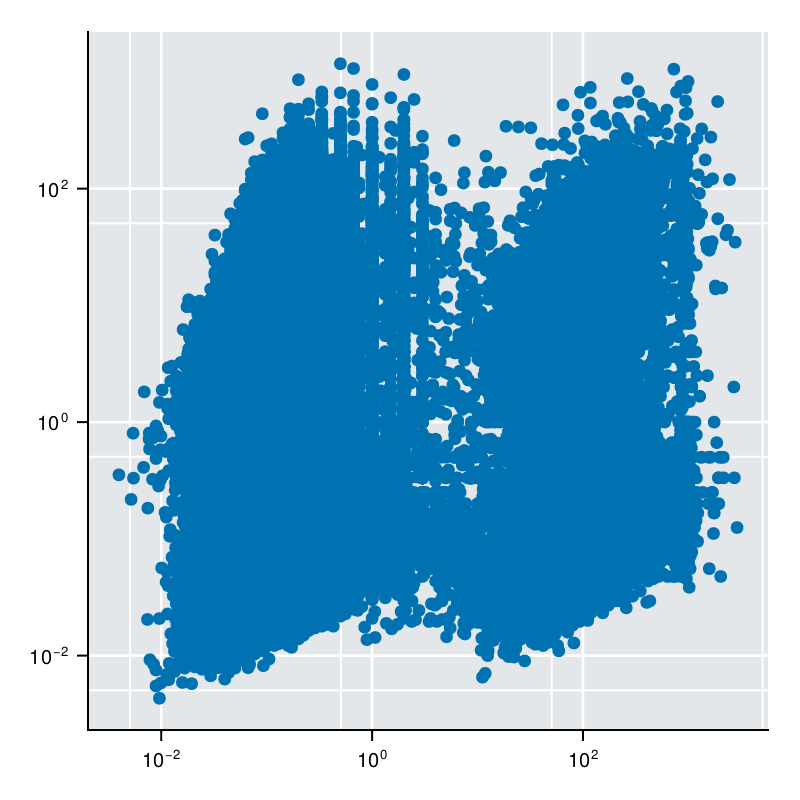

In [27]:
fig = Figure(size=(400, 400))
ax = Axis(fig[1, 1], xscale=log10, yscale=log10, xlabel="Ethanol 1", ylabel="Ethanol 2")
df = innerjoin(get_dataset("19-1"), get_dataset("19-2"), on=:barcode, makeunique=true)
scatter!(ax, df.relative_counts, df.relative_counts_1)

fig

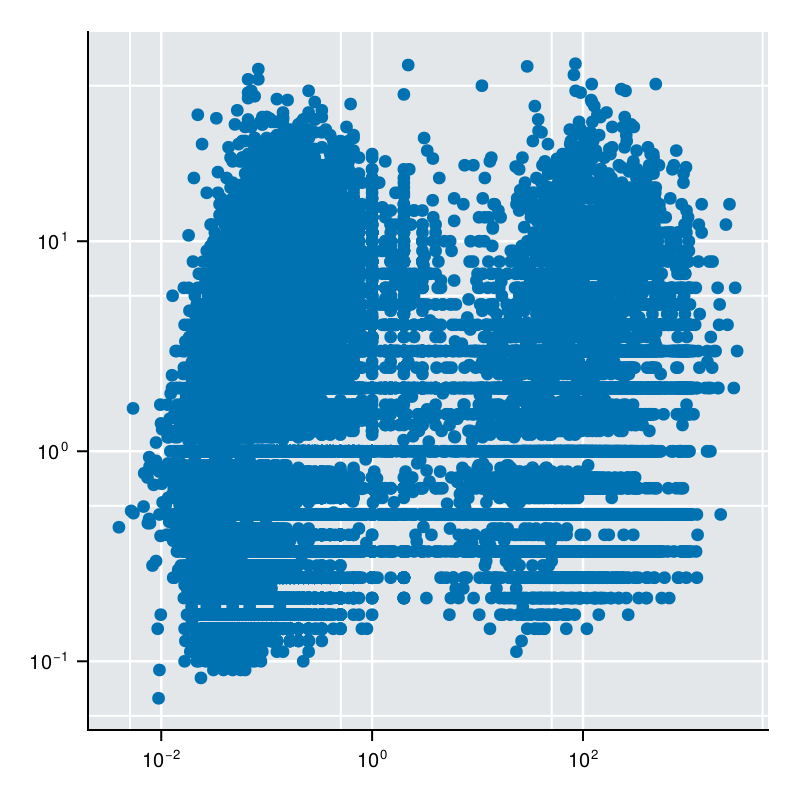

In [28]:
fig = Figure(size=(400, 400))
ax = Axis(fig[1, 1], xscale=log10, yscale=log10, xlabel="Ethanol 1", ylabel="LB 1")
df = innerjoin(get_dataset("19-1"), get_dataset("13-1"), on=:barcode, makeunique=true)
scatter!(ax, df.relative_counts, df.relative_counts_1)

fig